### Import Required Libraries:

In [ ]:
import pandas as pd
import numpy as np
from array import *
from scipy.signal import butter, filtfilt , find_peaks , lfilter , ellip
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

### Load the data

In [ ]:
# Load the data from CSV file
data = pd.read_csv('Val-12BPM.csv')

### Process the Data

In [ ]:
data.head()
data.loc[:,"CSI_DATA"]
index = list(range(0,len(data)-1))

AmpCSI=np.zeros((len(data),64))
PhaseCSI=np.zeros((len(data),64))


for i in index:
  parts = data.loc[:,"CSI_DATA"][i].split(' ')
  rawCSI=[s.strip('[') for s in parts]
  rawCSI.pop()

  ImCSI=np.array(rawCSI[::2],dtype=np.int64)
  ReCSI=np.array(rawCSI[1::2],dtype=np.int64)
  AmpCSI[i][:]=np.sqrt(np.power(ImCSI[:],2) + np.power(ReCSI[:],2))

  PhaseCSI[i][:]= np.arctan2(ImCSI[:], ReCSI[:])

Amp=np.concatenate((AmpCSI[:,6:32], AmpCSI[:,33:59]), axis=1)
Pha=np.concatenate((PhaseCSI[:,6:32], PhaseCSI[:,33:59]), axis=1)
csi_data = Amp

### Remove DC Offset

In [ ]:
# Remove the DC offset by subtracting the mean
signal_dc_removed = csi_data - np.mean(csi_data , axis=0)
print(signal_dc_removed.shape)

(12006, 52)


### Smoothing (Moving Average Filter):

In [ ]:
# def moving_average(data, window_size):
#     return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# # Example: Apply moving average to each column
# smoothed_signal = np.apply_along_axis(moving_average, 0, signal_dc_removed, window_size=5)

def smooth(a,WSZ):
    # a: NumPy 1-D array containing the data to be smoothed
    # WSZ: smoothing window size needs, which must be odd number,
    # as in the original MATLAB implementation
    out0 = np.convolve(a,np.ones(WSZ,dtype=int),'valid')/WSZ
    r = np.arange(1,WSZ-1,2)
    start = np.cumsum(a[:WSZ-1])[::2]/r
    stop = (np.cumsum(a[:-WSZ:-1])[::2]/r)[::-1]
    return np.concatenate((  start , out0, stop  ))
def movingAverage(signal, window):
    """
    Apply a moving average filter to each column of a 2D signal array.

    Parameters:
    - signal: 2D numpy array where each column represents a separate signal to smooth.
    - window: Size of the moving average window.

    Returns:
    - smoothed_signal: 2D numpy array of the same shape as the input signal.
    """
    # Initialize a 12006 x 52 array filled with zeros
    C2 = np.zeros((signal.shape[0],signal.shape[1] ))
    # Apply moving average to each column
    for i in range(signal.shape[1]):
      C2[:, i] = smooth(signal[:, i], window)

    # Optionally replace NaNs introduced by centering with 0 or other method
    # smoothed_signal = np.nan_to_num(smoothed_signal)

    return C2

# Apply moving average to each column
smoothed_signal = movingAverage(signal_dc_removed, window=5)

### Bandpass Filtering (0.1Hz to 0.6Hz):

In [ ]:
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order,[low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

# Parameters for the bandpass filter
fs = 100
lowcut = 0.1
highcut = 0.6

# Apply bandpass filtering to each subcarrier
filtered_signal = np.apply_along_axis(bandpass_filter, 0, signal_dc_removed, lowcut, highcut, fs)


# Design the bandpass filter


In [ ]:
# Design the bandpass filter using an elliptic filter
def ellip_bandpass(lowcut, highcut, fs, order=4, rp=1, rs=40):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    # Elliptic filter design
    b, a = ellip(order, rp, rs, [low, high], btype='band')
    return b, a

# Parameters for the bandpass filter
fs = 100        # Sampling frequency
lowcut = 0.1    # Lower cutoff frequency
highcut = 0.6   # Upper cutoff frequency
order = 4       # Filter order

# Design the filter
b, a = ellip_bandpass(lowcut, highcut, fs, order)

# Apply the filter to each channel in the signal
filtered_signal = np.zeros_like(smoothed_signal)
for i in range(smoothed_signal.shape[1]):
    # Use filtfilt to apply zero-phase filtering to avoid phase distortion
    filtered_signal[:, i] = filtfilt(b, a, smoothed_signal[:, i])

# PCA

In [ ]:
# Apply PCA to the filtered signal
pca = PCA()
pca.fit(filtered_signal)
pca_components = pca.transform(filtered_signal)

# Variance explained by each principal component
explained_variance = pca.explained_variance_

# Extract the first principal component
first_pc = pca_components[:, 0]
print(first_pc)


[-0.14281027 -0.2078207  -0.27247973 ...  0.41303896  0.40088722
  0.3849925 ]


### Power Spectral Density (PSD) Calculation:

In [ ]:
from scipy.signal import welch

def estimate_rr(data, fs=100):
    freqs, psd = welch(data, fs=fs, nperseg=len(data))

    freqs_symmetric = np.concatenate((-freqs[::-1], freqs))
    psd_symmetric = np.concatenate((psd[::-1], psd))

    # Identify the frequency with the highest PSD within the range
    peak_freq = freqs[np.argmax(psd)]

    # Convert peak frequency to breaths per minute
    rr_bpm = peak_freq * 60

    return rr_bpm, psd_symmetric, freqs_symmetric

# Example usage:
bpm, psd_in_range, freqs_in_range = estimate_rr(first_pc, fs=100)
print("respiration rate: ", bpm)


respiration rate:  9.495252373813093


### Visualisation

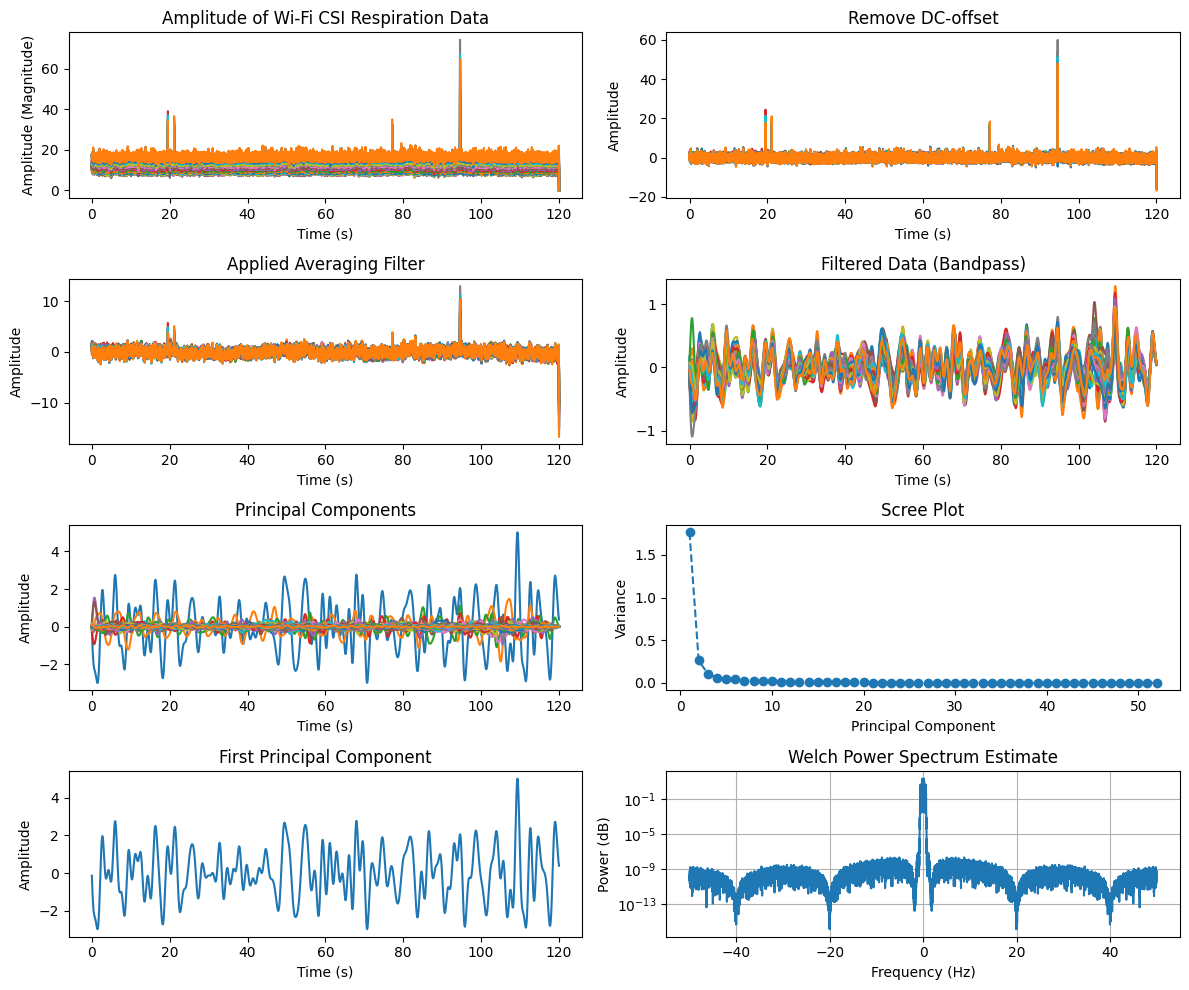

In [ ]:
# Create a time array for x-axis in seconds
time = np.arange(csi_data.shape[0]) / fs

# Plotting
plt.figure(figsize=(12, 10))


# Plot the amplitude over time
plt.subplot(4, 2, 1)
plt.plot(time, csi_data)
plt.title('Amplitude of Wi-Fi CSI Respiration Data')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (Magnitude)')


# 2. Remove DC-offset
plt.subplot(4, 2, 2)
plt.plot(time, signal_dc_removed)
plt.title('Remove DC-offset')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# 3. Applied Averaging Filter
plt.subplot(4, 2, 3)
plt.plot(time[:len(smoothed_signal)], smoothed_signal)
plt.title('Applied Averaging Filter')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# 4. Filtered Data (Bandpass)
plt.subplot(4, 2, 4)
plt.plot(time[:len(filtered_signal)], filtered_signal)  # Adjust time length for filtered signal
plt.title('Filtered Data (Bandpass)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# 5. Principal Components
plt.subplot(4, 2, 5)
plt.plot(time[:len(pca_components)], pca_components)  # Adjust time length for PCA components
plt.title('Principal Components')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# 6. Scree Plot
plt.subplot(4, 2, 6)
plt.plot(np.arange(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance')


# 7. First Principal Component
plt.subplot(4, 2, 7)
plt.plot(time[:len(first_pc)], first_pc)  # Adjust time length for first principal component
plt.title('First Principal Component')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# 8. Welch Power Spectrum Estimate
plt.subplot(4, 2, 8)
plt.semilogy(freqs_in_range, psd_in_range)
# plt.semilogy(freqs_symmetric, psd_symmetric)
plt.title('Welch Power Spectrum Estimate')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (dB)')

plt.grid()
plt.tight_layout()
plt.show()

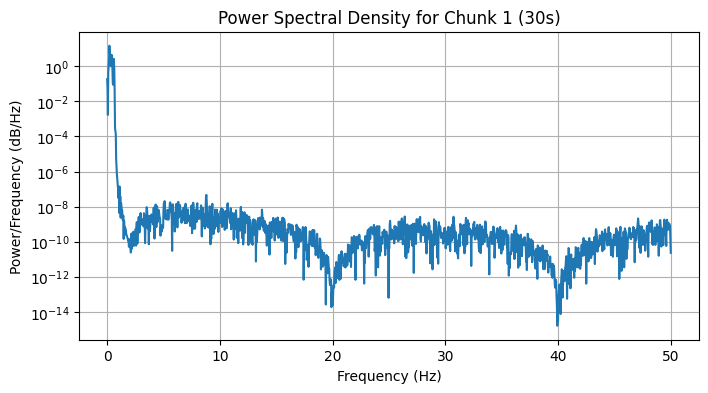

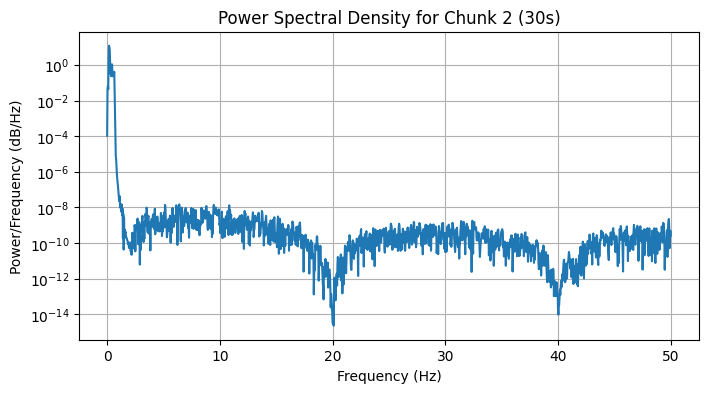

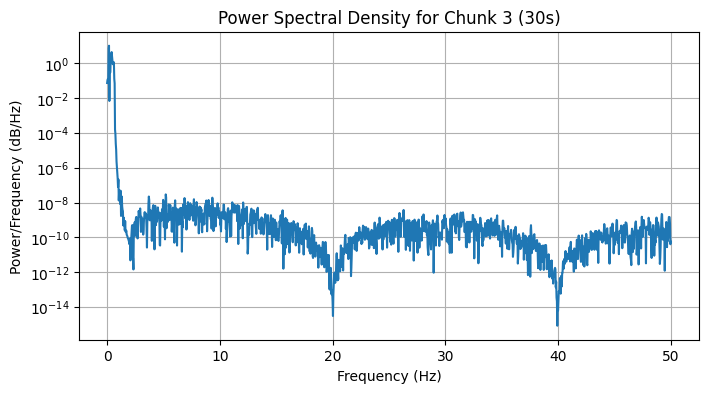

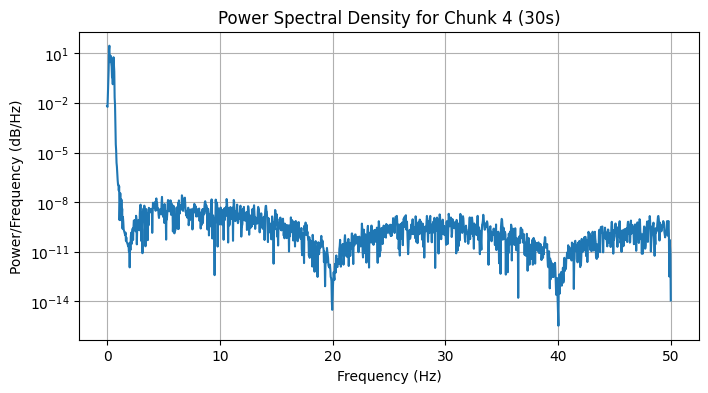

In [ ]:
chunk_size = 30 * fs
num_chunks = len(first_pc)//chunk_size
num_chunks

for i in range(num_chunks):
  chunk = first_pc[i * chunk_size:(i + 1) * chunk_size]
  freqs, psd = welch(chunk, fs=fs, nperseg=chunk_size)

  # Step 4: Plot the PSD
  plt.figure(figsize=(8, 4))
  plt.semilogy(freqs, psd)
  plt.title(f'Power Spectral Density for Chunk {i+1} (30s)')
  plt.xlabel('Frequency (Hz)')
  plt.ylabel('Power/Frequency (dB/Hz)')
  plt.grid(True)
  plt.show()